In [143]:
import random
import numpy as np
import os
from os import path
import time
import copy
import torch
from torch import nn
from gan_training.utils4nb import return_data_test
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from gan_training import utils
from gan_training.train import Trainer, update_average
from gan_training.logger import Logger
from gan_training.checkpoints import CheckpointIO
from gan_training.inputs import get_dataset
from gan_training.distributions import get_ydist, get_zdist
from gan_training.eval_test import DisentEvaluator, Evaluator
from gan_training.config4nb import (
    load_config, build_models, build_optimizers, build_lr_scheduler,
)


In [144]:

# Arguments

#args.config_dir='./configs'
config='cells_650.yaml'
VAEname= 'FactorVAE3'
#VAEname='BetaVAE_H'
config_dir='./configs'
output_dir= './outputs/'
Model_dir='./Models'
dset_dir='./ProcessedData/'
TrainDataset='CCy' 
TestDataset='LC'
Traverse=False

                   


In [145]:
#Lung Cancer=LC-141
#CellCycle=CCy-
#Cell Painting Assay=CPA-178-
#Epithelial to Mesenchymal Transition=EMT-161-

VAE_name='VAE' 
GAN_name='GAN'

config_path = os.path.join(config_dir, config)
config = load_config(config_path)

nf=-1 #Base number of filters

bs=32 #'Batch size'
reg_param=-1 #'R1 regularization parameter'
w_info =-1#'weighting constant on ID Loss')
mi=max_iter=-1 #'Max training iteration')
num_workers=0 #'dataloader num_workers'
image_size= 256         # Generator Image size
datatype='rgb' # options 'rbg' or 'cpa'. Choose cpa if reqires superimposition of multiple channels as in case of Cell Painting Assay dataset else it is rgb
nc= 3
Traverse_SaveIm=False
c_dim= 10 #Latent synthesis size'
z_dim=256 #type=int, help='Image synthesis size')

no_cuda=False #help='Do not use cuda')
seed=1 #type=int, help='Random Seed')
infodistil_mode=True #'Infodistill')


is_cuda = (torch.cuda.is_available() and not no_cuda)


In [146]:
VAE_chkptname='last'
GAN_chkptname='model.pt'
data_dir=os.path.join(dset_dir,TestDataset)
#out_dir = os.path.join(output_dir, name)
fvae_ckpt_path = os.path.join(Model_dir, TrainDataset, VAE_name,'chkpts',VAE_chkptname)
gan_ckpt_path = os.path.join(Model_dir, TrainDataset, GAN_name,'chkpts', GAN_chkptname)
     


In [147]:
device = torch.device("cuda:0" if is_cuda else "cpu")
device

device(type='cuda', index=0)

In [148]:

# Logger
checkpoint_io = CheckpointIO(
    checkpoint_dir=fvae_ckpt_path
)

device = torch.device("cuda:0" if is_cuda else "cpu")

train_dataset = get_dataset(
    name='image',
    data_dir=data_dir,
    size=image_size,
)
train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=bs,
        num_workers=3,
        shuffle=True, pin_memory=True, sampler=None, drop_last=True
)



In [149]:

#Create models
fvae, generator, discriminator = build_models(image_size, c_dim, nc, z_dim)
data_loader = return_data_test(TestDataset, datatype, dset_dir, bs, image_size)



In [150]:
selectVAE='fvae'

if selectVAE=='dvae':
    dvae_ckpt_path =  os.path.join(Model_dir, dataset, VAE_name,'chkpts', chkptname)

    dvae_ckpt = torch.load(dvae_ckpt_path, weights_only=True)
    #for key in list(dvae_ckpt_path.keys()):
    #    dvae_ckpt_path[key.replace('decoder.', 'module.decoder.'). replace('encoder.', 'module.encoder.')] = dvae_ckpt_path.pop(key)

    dvae.load_state_dict(dvae_ckpt_path)
else:


    fvae_ckpt = torch.load(fvae_ckpt_path)  #weights_only=True

    for key in list(fvae_ckpt['model_states']['VAE'].keys()):
        fvae_ckpt['model_states']['VAE'][key.replace('decode.', 'decoder.layer.').
                                         replace('decode.', 'decoder.layer.').
                                         replace('decode.', 'decoder.layer.').
                                         replace('decode.', 'decoder.layer.').
                                         replace('decode.', 'decoder.layer.').
                                         replace('encode.', 'encoder.layer.').
                                         replace('encode.', 'encoder.layer.').
                                         replace('encode.', 'encoder.layer.').
                                         replace('encode.', 'encoder.layer.').
                                         replace('encode.', 'encoder.layer.')] = fvae_ckpt['model_states']['VAE'].pop(key)


    fvae.load_state_dict(fvae_ckpt['model_states']['VAE'])

    dvae=fvae


In [151]:
# Put models on gpu if needed
dvae = dvae.to(device)
generator = generator.to(device)
discriminator = discriminator.to(device)

#g_optimizer, d_optimizer = build_optimizers(
#    generator, discriminator, dvae, config
#)

# Use multiple GPUs if possible
dvae = nn.DataParallel(dvae)
generator = nn.DataParallel(generator)
discriminator = nn.DataParallel(discriminator)

In [152]:

# Register modules to checkpoint
checkpoint_io.register_modules(
    generator=generator,
    discriminator=discriminator,
)
'''
# Logger
logger = Logger(
    log_dir=path.join(out_dir, 'logs'),
    img_dir=path.join(out_dir, 'imgs'),
    #monitoring=config['training']['monitoring'],
    #monitoring_dir=path.join(out_dir, 'monitoring')
)
'''

# Distributions
cdist = get_zdist('gauss',c_dim, device=device)
zdist = get_zdist('gauss', z_dim,
                  device=device)

 
# Save for tests
ntest = bs
#x_real, ytest = utils.get_nsamples(train_loader, ntest)
ztest = zdist.sample((ntest,))
ctest = cdist.sample((ntest,))
ztest_ = torch.cat([ztest, ctest], 1)

In [153]:

generator_test = generator

# Evaluator
dis_evaluator = DisentEvaluator(generator=generator_test, zdist=zdist, cdist=cdist,
                                batch_size=bs, device=device, dvae=dvae)
#data_loader = return_data_test()

# Train
tstart = t0 = time.time()
it = epoch_idx = -1

In [154]:
# Load checkpoint if existant
it=checkpoint_io.load(os.getcwd()+gan_ckpt_path)

# Training loop


=> Loading checkpoint...


In [155]:

mu_real_Dump=[]
mu_gen_Dump=[]
mu_real_All=[]
mu_gen_All=[]
label1=[]
label2=[]
travN_MainDir='./outputs/TraversalLoop/'
device

device(type='cuda', index=0)

In [156]:
t = time.time()

for x_true, path, label in data_loader:
    epoch_idx += 1

    #for x_real, _ in train_loader:
    
    x_true=x_true.to(device)

    mu_real, logvar, c_real = fvae(x_true, encode_only=True)
    print(c_real)
    
    recon_img=dis_evaluator.predict_image(c_real)
    recon_img=torch.stack(recon_img)
    mu_gen, logvar_gen, c_gen=fvae(recon_img, encode_only=True)
    
    mu_real_All.append(mu_real.detach().cpu())
    mu_gen_All.append(mu_gen.detach().cpu())
    
    
    mu, c_lat=dis_evaluator.predict_latent(x_true)
    if Traverse_SaveIm==True:
        if epoch_idx < 50:
            
            travN =  epoch_idx
            travN_dir = os.path.join(travN_MainDir, str(travN))
            #print('checkpoint_dir',checkpoint_dir)
            # Create missing directories
            if not os.path.exists(travN_dir):
                os.makedirs(travN_dir)
                
            c_lat_sample=c_lat
            z_sample=ztest[0]
            #c_lat_sample=c_lat_sample.unsqueeze(0)
            z_sample=z_sample.unsqueeze(0)
            travN
            ncol=dis_evaluator.traverse_c1z1(travN, z_sample, c_lat_sample, save='True', save_type='idgan', TravImRet='False', cmap='viridis')

## Sorting the feature tables according to order generated in the ImageGenerator 
    label1.append(label)
    label2.append(path)
    # do stuff
elapsed = time.time() - t
print('Time taken to complete testing this dataset=')
print(elapsed)

tensor([[-4.8890, -5.6769, -5.8820, -7.4288, -5.5395, -5.9341, -5.3183, -6.0244,
         -5.3322, -4.8150],
        [-5.5899, -6.3113, -6.2449, -7.8932, -6.7021, -7.2344, -5.7127, -6.6363,
         -5.9914, -5.4197],
        [-5.2508, -6.0315, -6.2056, -7.7457, -6.3096, -6.8098, -5.5608, -6.4548,
         -5.6928, -5.1948],
        [-5.2011, -5.9532, -6.0979, -7.8318, -6.0169, -6.6006, -5.5023, -6.4464,
         -5.6021, -5.0618],
        [-5.4291, -6.1457, -6.1141, -7.7666, -6.4695, -7.0714, -5.5152, -6.5379,
         -5.8105, -5.2387],
        [-5.1498, -5.9914, -6.0452, -7.8390, -6.1463, -6.8454, -5.4067, -6.3780,
         -5.6578, -5.0379],
        [-5.1317, -5.8349, -5.9361, -7.7117, -6.0291, -6.5626, -5.3418, -6.3553,
         -5.5844, -4.9269],
        [-4.7062, -5.6153, -5.8724, -7.2119, -5.4169, -5.6051, -5.3615, -5.9092,
         -5.2760, -4.7659],
        [-4.7298, -5.6279, -5.8716, -6.2475, -5.1877, -4.9692, -5.1381, -5.6182,
         -4.8058, -4.8526],
        [-5.2610, -

tensor([[-5.1960, -5.9101, -6.1885, -7.7938, -6.0063, -6.4044, -5.5937, -6.4387,
         -5.7680, -5.0203],
        [-4.7996, -5.5193, -5.7836, -7.3484, -5.6141, -6.1703, -5.2427, -5.9552,
         -5.2238, -4.7936],
        [-5.5813, -6.3537, -6.3235, -7.9526, -6.6616, -7.2577, -5.6958, -6.6790,
         -6.0069, -5.4359],
        [-4.8541, -5.5962, -5.8492, -5.8959, -5.2714, -4.6502, -4.8012, -5.3790,
         -4.5648, -4.6814],
        [-4.5643, -5.3536, -5.7643, -6.6394, -5.0566, -5.1114, -5.1454, -5.6323,
         -5.0311, -4.7046],
        [-5.3044, -6.0703, -6.3234, -7.9996, -6.1182, -6.5823, -5.7037, -6.5818,
         -5.9037, -5.1679],
        [-4.6002, -5.4685, -5.7873, -6.4725, -5.0499, -4.9879, -5.1740, -5.5653,
         -4.8252, -4.8141],
        [-5.5615, -6.2229, -6.2406, -7.8284, -6.6060, -7.1561, -5.6753, -6.6180,
         -5.9757, -5.3266],
        [-4.5520, -5.5305, -5.8181, -7.0072, -5.2753, -5.3701, -5.2963, -5.7837,
         -5.1640, -4.6299],
        [-4.7422, -

tensor([[-5.2910, -5.9903, -6.1334, -7.9936, -6.2271, -6.7384, -5.5822, -6.4741,
         -5.7419, -5.1181],
        [-5.1377, -5.8717, -5.9836, -7.6904, -5.8518, -6.5710, -5.3479, -6.3429,
         -5.5080, -4.8650],
        [-5.2763, -5.9157, -6.1466, -7.7514, -6.1985, -6.7336, -5.5315, -6.4344,
         -5.6149, -5.0576],
        [-4.8281, -5.7131, -6.0170, -7.0230, -5.3449, -5.4930, -5.4596, -5.9692,
         -5.2401, -5.0498],
        [-4.9770, -5.7906, -6.0207, -7.4402, -5.5954, -5.9160, -5.4691, -6.1102,
         -5.4311, -5.0649],
        [-5.5004, -6.2969, -6.1579, -7.9533, -6.6026, -7.1454, -5.5770, -6.6224,
         -5.8789, -5.3535],
        [-4.6078, -5.5705, -5.8771, -7.1573, -5.4138, -5.4256, -5.4381, -5.8655,
         -5.2244, -4.7282],
        [-4.9899, -5.7006, -5.8343, -7.4647, -5.7091, -6.1954, -5.2410, -6.1337,
         -5.4748, -4.7582],
        [-5.4915, -6.2645, -6.3530, -7.8012, -6.4000, -7.2307, -5.7114, -6.6262,
         -5.9407, -5.3624],
        [-4.9806, -

tensor([[-5.3489, -6.0230, -5.9859, -7.7615, -6.3626, -6.8849, -5.4466, -6.4654,
         -5.7539, -5.1644],
        [-4.9745, -5.4411, -5.9182, -7.2152, -5.4576, -5.6752, -5.2587, -5.8933,
         -5.4354, -4.7388],
        [-5.0663, -5.9043, -5.9242, -7.6529, -5.8890, -6.6690, -5.3032, -6.3050,
         -5.5833, -4.8725],
        [-5.3150, -6.0187, -6.1074, -7.8543, -6.2099, -6.7696, -5.4820, -6.5575,
         -5.7566, -5.0662],
        [-5.1716, -5.9835, -6.1310, -7.9193, -5.9525, -6.5654, -5.5395, -6.4203,
         -5.5928, -5.0550],
        [-4.7460, -5.4737, -5.6453, -7.1478, -5.3634, -5.7556, -5.1112, -5.7930,
         -5.1401, -4.6085],
        [-4.9039, -5.8153, -5.9407, -7.4315, -5.4806, -5.8362, -5.4021, -6.0826,
         -5.4255, -4.8447],
        [-5.1265, -6.0008, -6.0170, -7.7730, -6.1030, -6.8465, -5.3436, -6.3928,
         -5.6404, -4.9671],
        [-5.0926, -5.7942, -5.9580, -7.6993, -5.9757, -6.3909, -5.4081, -6.3224,
         -5.5580, -4.8527],
        [-5.3447, -

tensor([[-5.7603, -6.5362, -6.3687, -8.3754, -6.8783, -7.5030, -5.7820, -6.8540,
         -6.2081, -5.6494],
        [-4.9748, -5.7461, -6.0416, -7.6639, -5.8445, -6.1836, -5.5488, -6.2050,
         -5.4245, -5.0122],
        [-4.8290, -5.7635, -5.9426, -5.8885, -5.2992, -4.7152, -4.8758, -5.4521,
         -4.6073, -4.7543],
        [-4.6201, -5.4182, -5.7947, -7.2257, -5.4206, -5.7398, -5.3325, -5.7843,
         -5.0712, -4.8211],
        [-5.5871, -6.3813, -6.1926, -7.9048, -6.6473, -7.2930, -5.6859, -6.6872,
         -6.0103, -5.5153],
        [-5.0897, -5.9428, -6.1591, -7.7229, -5.7949, -6.2200, -5.5767, -6.3229,
         -5.6574, -5.0746],
        [-5.4590, -6.3207, -6.3134, -7.8991, -6.4694, -7.0921, -5.7236, -6.6266,
         -5.9090, -5.4543],
        [-5.0416, -5.7715, -6.0801, -7.8004, -5.9695, -6.5194, -5.4787, -6.2625,
         -5.5347, -4.9287],
        [-4.6540, -5.4653, -5.6703, -7.0969, -5.2978, -5.6050, -5.1944, -5.5480,
         -5.0094, -4.7405],
        [-5.4976, -

tensor([[-4.8284, -5.8660, -5.5621, -5.0130, -5.3235, -4.0038, -4.5240, -4.8891,
         -4.1799, -4.3186],
        [-5.1028, -5.9238, -6.0840, -7.6813, -6.0541, -6.8435, -5.4576, -6.4133,
         -5.6804, -4.8963],
        [-4.5327, -5.4629, -5.6743, -7.0559, -5.1383, -5.5049, -5.2179, -5.6493,
         -5.0725, -4.9065],
        [-4.6358, -5.5950, -5.8822, -6.9301, -5.2553, -5.3720, -5.2912, -5.7796,
         -5.0999, -4.8587],
        [-4.8411, -5.4768, -5.7736, -7.2628, -5.4562, -5.7855, -5.1884, -5.9370,
         -5.3489, -4.5062],
        [-4.8432, -5.6435, -5.9076, -7.5162, -5.6634, -6.1401, -5.3346, -6.0506,
         -5.3343, -4.8609],
        [-5.1878, -5.7061, -6.1566, -7.5931, -6.1657, -6.5475, -5.5621, -6.3009,
         -5.5617, -4.9376],
        [-4.6315, -5.5028, -5.6912, -7.0936, -5.2966, -5.5592, -5.1975, -5.7951,
         -5.1773, -4.5214],
        [-5.5258, -6.3053, -6.3399, -7.9057, -6.6156, -7.1694, -5.6502, -6.6817,
         -5.9127, -5.3622],
        [-5.0488, -

tensor([[-4.6997, -5.7114, -5.8890, -5.8762, -5.1222, -4.6608, -4.9108, -5.4237,
         -4.5283, -4.7794],
        [-5.0944, -5.8765, -6.0993, -7.8009, -6.0428, -6.5633, -5.5266, -6.3461,
         -5.6123, -4.9569],
        [-4.7725, -5.5570, -5.9285, -6.2571, -5.1287, -5.0017, -5.1647, -5.6330,
         -4.8689, -4.8973],
        [-4.7993, -5.7682, -5.9259, -7.4565, -5.5874, -6.0060, -5.3727, -6.0402,
         -5.2893, -4.8174],
        [-5.6392, -6.4382, -6.3825, -7.9050, -6.7088, -7.3720, -5.7847, -6.7269,
         -6.0448, -5.4937],
        [-5.6456, -6.3930, -6.4973, -7.9461, -6.7809, -7.2269, -5.8603, -6.8223,
         -6.0547, -5.4762],
        [-5.9025, -6.5465, -6.7508, -8.5502, -6.8446, -7.3672, -6.0607, -7.1043,
         -6.3854, -5.5315],
        [-4.8005, -5.9176, -5.9398, -6.0731, -5.2159, -4.9662, -4.8937, -5.6376,
         -4.7422, -4.8416],
        [-5.7880, -6.6700, -6.4697, -8.0311, -7.0014, -7.4179, -5.9939, -6.8647,
         -6.2438, -5.8358],
        [-5.6548, -

tensor([[-4.8333, -5.7444, -5.6872, -5.4779, -5.2539, -4.3997, -4.6189, -5.1861,
         -4.2923, -4.4040],
        [-5.0812, -5.7930, -6.1068, -7.7280, -5.9828, -6.3780, -5.5578, -6.2707,
         -5.4966, -5.0455],
        [-5.0378, -5.7737, -5.9976, -7.6762, -5.9243, -6.3707, -5.4563, -6.2664,
         -5.5448, -4.9305],
        [-4.7933, -5.4718, -5.8483, -6.3281, -5.0301, -5.0882, -4.9971, -5.6857,
         -5.0119, -4.7605],
        [-5.4370, -6.1691, -6.1478, -7.9084, -6.4254, -7.0489, -5.5104, -6.5561,
         -5.8342, -5.2478],
        [-5.2816, -5.9547, -5.8846, -7.6693, -6.2195, -6.7261, -5.4230, -6.3789,
         -5.6778, -5.1509],
        [-4.9219, -5.6687, -5.9175, -7.5092, -5.6733, -6.1558, -5.3288, -6.0847,
         -5.4055, -4.8540],
        [-4.8899, -5.5953, -5.7765, -6.4157, -5.3255, -5.1631, -4.9227, -5.5867,
         -5.1996, -4.7401],
        [-4.8573, -5.6543, -5.9146, -7.4632, -5.5897, -6.0618, -5.3500, -6.0254,
         -5.3134, -4.8353],
        [-5.0313, -

tensor([[-5.5282, -6.3567, -6.1388, -7.8922, -6.5959, -7.1049, -5.6537, -6.6128,
         -5.9169, -5.5550],
        [-4.6955, -5.5497, -5.7751, -7.3064, -5.4715, -5.9287, -5.2644, -5.8204,
         -5.1483, -4.7708],
        [-4.9410, -5.6605, -5.9429, -7.5548, -5.8059, -6.2132, -5.4948, -6.1219,
         -5.3702, -4.9402],
        [-5.1586, -5.9664, -6.1128, -7.7941, -6.0602, -6.8008, -5.5588, -6.3975,
         -5.5986, -5.1951],
        [-5.0214, -5.8239, -6.0672, -7.6806, -6.1215, -6.6980, -5.5071, -6.2349,
         -5.5028, -5.1212],
        [-5.4487, -6.1761, -6.3152, -8.1715, -6.5142, -7.1130, -5.5893, -6.6297,
         -5.9082, -5.1170],
        [-5.1924, -5.9465, -6.1232, -7.7062, -6.2217, -6.7487, -5.5141, -6.4077,
         -5.6567, -5.1287],
        [-6.0435, -6.7633, -6.8238, -8.0092, -7.2072, -7.4989, -6.2775, -7.1589,
         -6.3957, -6.0017],
        [-5.4048, -6.1479, -6.0866, -7.8921, -6.3132, -6.9955, -5.5211, -6.5252,
         -5.7897, -5.2546],
        [-4.9482, -

tensor([[-5.2833, -6.2467, -6.3904, -8.0557, -6.2864, -6.8799, -5.7565, -6.6100,
         -5.7649, -5.2717],
        [-4.6593, -5.4418, -5.7786, -7.2435, -5.4959, -5.8891, -5.2134, -5.8277,
         -5.1348, -4.7019],
        [-5.2674, -6.0248, -5.9977, -7.6805, -6.1915, -6.8341, -5.4114, -6.3809,
         -5.7009, -5.1236],
        [-4.9547, -5.6349, -5.7164, -7.3866, -5.4682, -6.0322, -5.1568, -5.9858,
         -5.2753, -4.7066],
        [-4.6678, -5.4262, -5.6697, -7.0518, -5.2056, -5.5397, -5.1803, -5.6743,
         -5.0292, -4.6800],
        [-5.1810, -5.9178, -5.9045, -7.7237, -5.9878, -6.5865, -5.2928, -6.3319,
         -5.5939, -4.9783],
        [-4.8278, -5.6543, -5.9357, -7.2645, -5.4640, -5.6864, -5.4108, -5.9380,
         -5.3638, -4.8028],
        [-4.8517, -6.0151, -6.0750, -6.1012, -5.3038, -5.0237, -5.0390, -5.6728,
         -4.8036, -4.9831],
        [-4.8879, -5.6431, -5.8863, -7.5207, -5.7494, -6.3253, -5.3066, -6.0695,
         -5.3626, -4.8516],
        [-4.7997, -

tensor([[-5.4014, -6.1483, -6.0944, -7.6859, -6.4736, -7.0551, -5.4946, -6.5021,
         -5.7985, -5.2653],
        [-5.1624, -5.9223, -6.1208, -7.8298, -6.0840, -6.6759, -5.5335, -6.3966,
         -5.5938, -5.0613],
        [-4.7870, -5.5224, -5.8347, -6.4576, -5.1455, -5.1480, -5.0510, -5.6968,
         -5.0243, -4.7498],
        [-4.8637, -5.7292, -5.9423, -6.1859, -5.2227, -5.0397, -5.0037, -5.6928,
         -4.8918, -4.8151],
        [-5.7218, -6.5656, -6.3467, -7.9566, -6.9437, -7.5579, -5.8670, -6.8533,
         -6.1557, -5.7316],
        [-4.9017, -5.7177, -6.0368, -7.2486, -5.5669, -5.7969, -5.4408, -6.0079,
         -5.4318, -4.9674],
        [-5.2620, -5.9370, -6.1180, -7.8714, -6.1590, -6.7435, -5.4855, -6.4586,
         -5.6860, -5.0012],
        [-4.9495, -5.9018, -5.9681, -5.9252, -5.4143, -4.8004, -4.8426, -5.5018,
         -4.6172, -4.7925],
        [-5.3309, -5.9262, -6.1337, -7.7657, -6.0954, -6.4442, -5.4676, -6.2621,
         -5.7151, -4.9612],
        [-5.1913, -

tensor([[-4.7009, -5.5137, -5.8275, -6.0400, -5.1857, -4.7201, -4.9469, -5.4128,
         -4.6296, -4.7761],
        [-5.4485, -6.3714, -6.1607, -7.8945, -6.5962, -7.2348, -5.6022, -6.5856,
         -5.8822, -5.4899],
        [-4.2992, -5.2771, -5.6826, -6.4650, -4.9765, -4.9104, -5.1363, -5.3678,
         -4.7437, -4.6812],
        [-4.8982, -5.8974, -6.0291, -7.5313, -5.6722, -5.9787, -5.4529, -6.1825,
         -5.5712, -4.8012],
        [-4.8170, -5.7270, -5.8927, -7.4884, -5.6724, -6.1305, -5.4470, -5.9422,
         -5.3287, -4.9112],
        [-5.8883, -6.5881, -6.6244, -7.9418, -7.0353, -7.4142, -6.1090, -6.9499,
         -6.2797, -5.7581],
        [-4.9744, -5.5355, -5.9645, -7.1605, -5.4244, -5.6017, -5.3431, -5.8203,
         -5.3243, -4.8948],
        [-4.8169, -6.1170, -5.5115, -4.8370, -5.3610, -3.8931, -4.6093, -4.8263,
         -4.1075, -4.2966],
        [-5.4266, -6.1090, -6.1136, -7.6676, -6.3934, -6.8495, -5.6377, -6.5624,
         -5.8610, -5.3429],
        [-4.8048, -

tensor([[-4.5879, -5.4044, -5.7994, -6.7842, -5.1395, -5.2359, -5.2687, -5.6620,
         -5.0190, -4.7324],
        [-5.2004, -5.9155, -5.8837, -7.6593, -6.0606, -6.7141, -5.2890, -6.3216,
         -5.6415, -4.9530],
        [-4.5735, -5.3339, -5.8251, -6.6790, -5.0581, -5.1422, -5.2045, -5.6434,
         -5.0630, -4.7357],
        [-4.6583, -5.5864, -5.9330, -7.0207, -5.2839, -5.4731, -5.3878, -5.8342,
         -5.1364, -4.9136],
        [-5.1972, -6.0041, -6.1198, -7.8870, -6.0555, -6.6528, -5.5805, -6.4007,
         -5.5563, -5.2825],
        [-5.2156, -5.9277, -6.0183, -7.7304, -6.1786, -6.7857, -5.4075, -6.4158,
         -5.6281, -5.0289],
        [-5.2771, -5.9442, -6.0985, -7.8261, -6.1634, -6.7015, -5.5080, -6.4512,
         -5.7067, -5.0973],
        [-4.8837, -5.7306, -5.9939, -7.4527, -5.6091, -5.8412, -5.4881, -6.0033,
         -5.3555, -4.9711],
        [-4.8457, -5.5666, -5.9798, -6.3117, -5.1481, -5.1163, -5.0308, -5.7033,
         -5.0322, -4.8382],
        [-4.7544, -

tensor([[-4.8949, -5.6106, -5.9471, -7.5458, -5.7942, -6.2106, -5.4290, -6.0941,
         -5.3654, -4.8645],
        [-5.0821, -5.9272, -6.0847, -7.6870, -5.7548, -6.2110, -5.4980, -6.3461,
         -5.6183, -5.0173],
        [-5.6728, -6.4132, -6.4190, -8.0430, -6.8469, -7.3337, -5.8252, -6.8764,
         -6.1054, -5.4599],
        [-4.5769, -5.2608, -5.6037, -6.8706, -5.1430, -5.3048, -5.0593, -5.6424,
         -5.1166, -4.4091],
        [-4.8695, -5.8435, -5.7522, -5.5101, -5.3021, -4.4878, -4.6606, -5.3343,
         -4.4642, -4.4830],
        [-5.1261, -5.7708, -5.9512, -7.6331, -6.0730, -6.5695, -5.3725, -6.2791,
         -5.5498, -4.9416],
        [-5.3938, -6.1658, -6.3329, -8.1876, -6.5162, -7.0994, -5.6868, -6.6201,
         -5.8385, -5.2161],
        [-4.7602, -5.4999, -5.8482, -7.2685, -5.4453, -5.7434, -5.3559, -5.8492,
         -5.1980, -4.7401],
        [-5.0460, -5.7703, -6.0304, -7.6892, -5.9444, -6.4449, -5.5243, -6.2723,
         -5.4831, -4.9824],
        [-4.9249, -

tensor([[-5.4686, -6.1923, -6.2576, -8.0200, -6.4568, -6.9683, -5.6195, -6.5568,
         -5.8293, -5.2936],
        [-6.0596, -6.6711, -6.7497, -8.1075, -7.1968, -7.5967, -6.1846, -7.1138,
         -6.4008, -5.7949],
        [-5.5677, -6.3220, -6.3738, -8.0976, -6.5600, -7.3021, -5.7392, -6.6776,
         -6.0914, -5.3845],
        [-5.3949, -6.1996, -6.1172, -7.7983, -6.4094, -7.0487, -5.5639, -6.5665,
         -5.8180, -5.3225],
        [-4.5028, -5.2999, -5.7533, -6.6149, -5.0592, -5.1393, -5.1474, -5.5261,
         -4.8070, -4.8334],
        [-4.8217, -5.6949, -5.8754, -6.1427, -5.2953, -4.8741, -4.9823, -5.5480,
         -4.6912, -4.8287],
        [-4.7230, -5.3284, -5.5980, -6.8949, -5.1830, -5.3953, -5.0551, -5.7019,
         -5.1688, -4.5018],
        [-5.3219, -5.9560, -6.0864, -7.9017, -6.1935, -6.6502, -5.5610, -6.4849,
         -5.7070, -5.1203],
        [-5.5446, -6.3290, -6.1939, -7.8447, -6.5706, -7.1676, -5.6719, -6.6320,
         -5.9554, -5.4521],
        [-4.6564, -

tensor([[-5.5197, -6.3739, -6.3991, -7.8977, -6.5824, -7.2486, -5.7749, -6.7111,
         -5.9326, -5.4452],
        [-5.1857, -5.8681, -5.9144, -7.6994, -6.0361, -6.6444, -5.3588, -6.3374,
         -5.5740, -5.0037],
        [-4.8209, -5.6709, -5.8679, -5.9508, -5.2790, -4.7333, -4.8679, -5.4365,
         -4.5975, -4.6957],
        [-4.8708, -5.7471, -5.9262, -5.9830, -5.2074, -4.8627, -4.8832, -5.5867,
         -4.7388, -4.7484],
        [-4.7070, -5.6673, -5.9960, -6.2708, -5.1632, -4.9883, -5.1486, -5.6660,
         -4.8422, -4.9687],
        [-4.7090, -5.5321, -5.7448, -7.2562, -5.4246, -5.8191, -5.1807, -5.8751,
         -5.1541, -4.7397],
        [-4.9138, -5.7001, -5.9840, -7.6203, -5.6998, -6.1048, -5.4822, -6.1136,
         -5.3626, -4.9014],
        [-4.7688, -5.4846, -5.7472, -7.1823, -5.3718, -5.7313, -5.2011, -5.8025,
         -5.1521, -4.6904],
        [-4.7339, -5.5124, -5.7085, -7.1630, -5.3115, -5.6889, -5.1701, -5.8633,
         -5.2007, -4.5801],
        [-4.9448, -

tensor([[-4.9804, -5.7019, -5.8926, -7.5442, -5.6955, -6.1283, -5.3330, -6.1112,
         -5.4325, -4.8428],
        [-5.0749, -5.7672, -6.0501, -7.6947, -6.0233, -6.4522, -5.5267, -6.2822,
         -5.5314, -4.9787],
        [-4.9095, -5.8475, -5.8664, -5.6434, -5.4650, -4.4495, -4.7178, -5.2378,
         -4.3709, -4.5298],
        [-4.9585, -5.8069, -5.8978, -6.5996, -5.3925, -5.2995, -5.0472, -5.8115,
         -5.0978, -4.8279],
        [-5.0910, -5.8841, -6.1020, -7.7474, -6.0168, -6.4715, -5.5552, -6.3432,
         -5.5835, -4.9251],
        [-4.4617, -5.3907, -5.6801, -6.6939, -5.0550, -5.1437, -5.1442, -5.5808,
         -4.9246, -4.6336],
        [-5.5517, -6.3189, -6.2782, -7.8331, -6.7123, -7.2721, -5.6696, -6.6755,
         -5.9902, -5.3615],
        [-4.7245, -5.5103, -5.6662, -7.1265, -5.4064, -5.6799, -5.1668, -5.8357,
         -5.2513, -4.4975],
        [-5.0224, -5.8934, -6.0109, -7.7029, -5.7248, -6.2615, -5.4580, -6.2505,
         -5.4591, -4.9339],
        [-4.9130, -

tensor([[-5.5106, -6.2631, -6.3922, -8.0511, -6.4229, -7.1256, -5.7484, -6.7362,
         -6.1277, -5.3513],
        [-5.2893, -6.0470, -6.0446, -7.8610, -6.2162, -6.7810, -5.4557, -6.4827,
         -5.7557, -5.1634],
        [-4.9885, -5.8032, -6.1055, -7.7745, -6.0115, -6.5878, -5.4921, -6.2295,
         -5.5188, -4.8881],
        [-4.9503, -5.8724, -5.9036, -5.8904, -5.3122, -4.7998, -4.7992, -5.5176,
         -4.6208, -4.7364],
        [-5.5108, -6.2883, -6.2537, -8.0052, -6.5735, -7.2546, -5.5939, -6.6546,
         -5.9210, -5.3109],
        [-4.5680, -5.4967, -5.8602, -6.9255, -5.2787, -5.3625, -5.3129, -5.7813,
         -5.1267, -4.7156],
        [-5.0357, -5.8062, -6.0909, -7.7919, -5.9384, -6.4704, -5.4701, -6.3009,
         -5.5189, -4.9260],
        [-4.6068, -5.4547, -5.7661, -7.1519, -5.2947, -5.6213, -5.2282, -5.7584,
         -5.0539, -4.7210],
        [-4.8400, -5.6624, -5.9599, -7.3826, -5.6168, -5.9044, -5.4378, -6.0547,
         -5.4195, -4.8655],
        [-5.1594, -

tensor([[-4.9604, -6.2947, -5.7625, -5.0956, -5.5795, -4.0652, -4.7223, -4.9930,
         -4.1112, -4.4223],
        [-5.4725, -6.2606, -6.3197, -7.9845, -6.5184, -7.1278, -5.6453, -6.6741,
         -5.9081, -5.2675],
        [-4.8458, -5.8484, -5.7077, -5.4029, -5.2716, -4.3529, -4.6011, -5.2271,
         -4.3294, -4.4228],
        [-4.6726, -5.5314, -5.9687, -6.2696, -5.0777, -4.9911, -5.0748, -5.5782,
         -4.8186, -4.9925],
        [-5.1498, -5.8640, -6.0906, -7.8264, -6.0927, -6.5869, -5.5424, -6.3882,
         -5.5865, -4.9720],
        [-5.8786, -6.5520, -6.5831, -7.8687, -6.9801, -7.4903, -5.9570, -6.9489,
         -6.2115, -5.6770],
        [-5.2743, -6.0908, -6.0419, -7.6774, -6.2580, -7.0750, -5.3715, -6.4089,
         -5.6970, -5.1450],
        [-4.8806, -5.5668, -5.7711, -7.3251, -5.4539, -5.8825, -5.2455, -5.9109,
         -5.2680, -4.6578],
        [-5.5697, -6.3557, -6.3311, -7.9177, -6.6356, -7.2955, -5.6908, -6.6388,
         -5.9955, -5.3698],
        [-5.3720, -

tensor([[-5.9381, -6.6631, -6.7769, -8.0990, -7.0001, -7.2575, -6.2142, -7.0136,
         -6.2791, -5.8071],
        [-5.4660, -6.3399, -6.2198, -7.8762, -6.5634, -7.1613, -5.6608, -6.5757,
         -5.8935, -5.4664],
        [-5.3621, -6.0692, -6.1069, -7.6550, -6.4814, -6.8951, -5.5284, -6.4708,
         -5.7540, -5.2195],
        [-5.4299, -6.1588, -6.1277, -7.9162, -6.3699, -7.0789, -5.4683, -6.5263,
         -5.7797, -5.2008],
        [-5.3224, -5.9352, -5.9653, -7.6488, -6.1703, -6.7535, -5.3746, -6.4186,
         -5.7113, -5.0306],
        [-5.4440, -6.2447, -6.1352, -7.9226, -6.4253, -6.9861, -5.6546, -6.5781,
         -5.8293, -5.4488],
        [-4.7712, -5.7503, -5.8399, -5.8146, -5.2061, -4.6304, -4.8171, -5.3798,
         -4.5001, -4.6861],
        [-4.8955, -5.6199, -5.9174, -7.4520, -5.6318, -6.0417, -5.3592, -6.0927,
         -5.3369, -4.8623],
        [-5.2936, -5.9696, -6.0593, -7.7472, -6.2493, -6.7452, -5.5302, -6.3945,
         -5.6987, -5.1334],
        [-5.4205, -

tensor([[-4.6043, -5.5736, -5.8922, -7.1598, -5.3502, -5.5417, -5.4050, -5.8607,
         -5.1540, -4.8859],
        [-4.8951, -5.2472, -5.7862, -6.9873, -5.2675, -5.4728, -5.1340, -5.8074,
         -5.4893, -4.6239],
        [-4.6300, -5.4563, -5.7889, -6.9041, -5.1955, -5.3471, -5.2391, -5.6853,
         -5.0801, -4.6946],
        [-4.8476, -5.4510, -5.9421, -6.6288, -5.2437, -5.2713, -5.1796, -5.6828,
         -5.1206, -4.9033],
        [-4.8515, -5.7431, -5.7995, -5.8455, -5.2547, -4.7231, -4.8313, -5.5048,
         -4.6260, -4.5459],
        [-4.8637, -5.6749, -6.0095, -6.4412, -5.2311, -5.1968, -5.1599, -5.8286,
         -5.0731, -4.9541],
        [-4.7936, -5.4913, -5.6142, -7.1734, -5.2788, -5.8218, -5.0472, -5.8754,
         -5.1371, -4.6842],
        [-5.2008, -5.8982, -6.1443, -7.8388, -6.2096, -6.6621, -5.5755, -6.3704,
         -5.6151, -5.1407],
        [-5.5332, -6.2448, -6.2776, -7.7824, -6.6285, -7.0909, -5.6727, -6.6224,
         -5.9524, -5.3511],
        [-4.7856, -

tensor([[-5.0071, -5.8211, -6.0056, -6.4402, -5.3786, -5.2774, -5.1075, -5.8202,
         -5.0568, -4.8802],
        [-5.2645, -5.9194, -6.0497, -7.8430, -6.1476, -6.6883, -5.4469, -6.4292,
         -5.7284, -4.9612],
        [-4.9414, -5.8406, -5.7001, -5.4103, -5.4659, -4.2683, -4.5110, -5.0784,
         -4.2037, -4.3378],
        [-4.8916, -5.5523, -5.9298, -6.5481, -5.2019, -5.2643, -4.9894, -5.7623,
         -5.1680, -4.7649],
        [-4.8949, -5.3841, -5.8381, -6.9882, -5.3384, -5.5141, -5.1918, -5.8494,
         -5.4113, -4.6699],
        [-4.9348, -5.5638, -6.0589, -6.9525, -5.4299, -5.5272, -5.3435, -5.8618,
         -5.3297, -5.0082],
        [-5.1842, -5.8478, -6.0595, -7.8414, -6.0384, -6.5798, -5.4530, -6.3474,
         -5.6047, -4.8752],
        [-4.6513, -5.4598, -5.8513, -6.0247, -5.1086, -4.6940, -4.8665, -5.3542,
         -4.6944, -4.7178],
        [-4.7887, -5.6781, -5.4839, -5.0961, -5.1993, -4.0991, -4.3784, -4.9614,
         -4.2116, -4.1415],
        [-4.7358, -

tensor([[-5.0657, -5.7698, -6.0693, -7.7581, -6.0168, -6.4556, -5.5182, -6.2303,
         -5.5732, -4.7957],
        [-5.1806, -5.7372, -6.0546, -7.6032, -5.8940, -6.2389, -5.4380, -6.1174,
         -5.5768, -4.8567],
        [-4.7874, -5.0602, -5.8502, -6.6538, -5.0795, -5.2132, -5.0300, -5.7239,
         -5.3333, -4.6393],
        [-4.8041, -5.8786, -6.0653, -6.3496, -5.2170, -5.2049, -5.1268, -5.7423,
         -4.9813, -4.9675],
        [-4.7147, -4.9682, -5.5938, -6.0800, -4.7133, -4.7912, -4.7618, -5.4349,
         -5.0553, -4.4086],
        [-4.6151, -5.9824, -4.8927, -5.5698, -5.3672, -4.4012, -4.8820, -5.1005,
         -4.7872, -4.4003],
        [-4.7253, -5.5305, -5.7296, -7.1001, -5.2449, -5.4764, -5.2422, -5.8446,
         -5.2322, -4.6280],
        [-5.2536, -5.9504, -6.1765, -7.9530, -6.1972, -6.7698, -5.4973, -6.4296,
         -5.6882, -4.9507],
        [-4.4832, -5.3347, -5.6007, -6.8847, -5.2287, -5.3388, -5.2530, -5.4276,
         -4.8727, -4.7151],
        [-4.8586, -

tensor([[-4.8958, -5.5003, -5.8025, -7.2573, -5.4253, -5.7653, -5.2264, -5.9245,
         -5.3215, -4.5696],
        [-4.8032, -5.6298, -5.7227, -5.8546, -5.0789, -4.8411, -4.6886, -5.4618,
         -4.7944, -4.4990],
        [-4.7860, -5.5602, -5.7810, -6.0589, -5.0772, -4.8818, -4.8658, -5.5534,
         -4.7849, -4.6429],
        [-4.7087, -5.8481, -5.4092, -5.0428, -5.1229, -4.1627, -4.6134, -5.0582,
         -4.4594, -4.2837],
        [-5.2350, -5.8126, -6.0629, -7.7090, -6.0061, -6.5624, -5.3485, -6.3280,
         -5.6927, -4.8104],
        [-4.8740, -5.8319, -5.6867, -5.6243, -5.2528, -4.6269, -4.6358, -5.4385,
         -4.6316, -4.4128],
        [-4.8456, -5.2385, -5.9351, -6.8922, -5.2324, -5.3951, -5.1834, -5.7597,
         -5.3379, -4.7848],
        [-4.7346, -5.6576, -5.8265, -5.9270, -5.0725, -4.8325, -4.8634, -5.4792,
         -4.7315, -4.6635],
        [-5.1866, -5.9008, -6.1406, -7.9438, -6.0549, -6.5085, -5.5908, -6.4014,
         -5.6874, -4.9769],
        [-4.8090, -

tensor([[-4.9646, -5.5666, -5.9160, -7.0332, -5.4389, -5.6309, -5.2135, -5.7815,
         -5.3141, -4.8021],
        [-4.5674, -5.3404, -5.6298, -6.8525, -5.2053, -5.3173, -5.1679, -5.6088,
         -5.0428, -4.4268],
        [-4.8596, -5.5723, -5.9450, -7.2150, -5.4434, -5.6313, -5.3458, -5.9678,
         -5.4223, -4.7638],
        [-5.0935, -5.9744, -6.0729, -7.7034, -5.8428, -6.2635, -5.4938, -6.3287,
         -5.6683, -4.8150],
        [-4.8220, -5.7019, -5.7578, -5.5502, -5.0878, -4.5582, -4.6999, -5.4028,
         -4.6276, -4.4776],
        [-4.8349, -5.4238, -5.8684, -5.9140, -5.1141, -4.6881, -4.7762, -5.3949,
         -4.6814, -4.6647],
        [-4.9685, -5.7785, -6.0054, -7.2545, -5.5967, -5.7888, -5.4029, -6.0787,
         -5.5465, -4.8349],
        [-4.6563, -5.3052, -5.8385, -6.5047, -5.0265, -5.1259, -5.0922, -5.6738,
         -5.1149, -4.7500],
        [-5.1886, -5.8540, -6.2062, -7.8699, -6.0843, -6.6207, -5.5377, -6.2905,
         -5.6470, -4.8369],
        [-5.0484, -

tensor([[-4.8214, -5.6202, -5.5048, -5.3108, -5.1525, -4.2900, -4.3870, -5.1203,
         -4.3351, -4.1978],
        [-4.8206, -5.2402, -5.7288, -6.2652, -5.0120, -5.0048, -4.8041, -5.5024,
         -5.1127, -4.5289],
        [-4.8199, -5.2856, -5.6874, -6.6568, -5.1586, -5.2461, -4.9534, -5.5732,
         -5.1091, -4.6022],
        [-5.0539, -5.8016, -6.0838, -7.6760, -5.9021, -6.2336, -5.5314, -6.1928,
         -5.5729, -4.8300],
        [-5.2650, -5.9904, -6.1015, -7.9343, -6.1634, -6.7729, -5.4396, -6.4892,
         -5.7983, -4.9529],
        [-4.8488, -5.8051, -5.5832, -5.4077, -5.2238, -4.4658, -4.6395, -5.3093,
         -4.5429, -4.3431],
        [-4.7418, -5.5371, -5.7788, -5.9550, -5.1104, -4.7231, -4.7742, -5.4031,
         -4.6583, -4.6343],
        [-4.8964, -5.4469, -5.9194, -6.4977, -5.1946, -5.2233, -4.9454, -5.7076,
         -5.1850, -4.7521],
        [-4.9578, -5.5032, -5.9198, -6.8289, -5.3124, -5.4556, -5.0539, -5.8062,
         -5.3419, -4.7534],
        [-5.1115, -

tensor([[-5.9418, -6.7325, -6.6920, -8.1082, -7.1140, -7.5183, -6.1551, -7.0127,
         -6.3714, -5.8402],
        [-4.8904, -5.6921, -5.8687, -6.5658, -5.2464, -5.3114, -4.9753, -5.7561,
         -5.0902, -4.7219],
        [-4.8443, -5.5471, -5.9175, -7.0264, -5.3689, -5.5308, -5.2725, -5.8215,
         -5.2666, -4.8295],
        [-4.6755, -5.4287, -5.9060, -6.7454, -5.3420, -5.5622, -5.2453, -5.6060,
         -5.0251, -4.7562],
        [-5.4220, -6.0656, -6.1198, -7.9462, -6.3230, -6.9384, -5.5451, -6.5200,
         -5.7876, -5.1781],
        [-5.0361, -5.7493, -5.8827, -7.5737, -5.6872, -6.3800, -5.1846, -6.1552,
         -5.4288, -4.6755],
        [-4.7974, -5.7872, -5.7249, -5.3909, -5.2509, -4.3153, -4.5956, -5.1635,
         -4.3000, -4.4165],
        [-5.1238, -5.7777, -6.1027, -7.7789, -6.0335, -6.6402, -5.4526, -6.3425,
         -5.5801, -4.8252],
        [-5.2520, -5.9863, -6.1482, -7.9327, -6.1629, -6.7680, -5.5261, -6.4875,
         -5.6872, -5.0742],
        [-5.0615, -

tensor([[-4.8889, -5.6109, -5.6214, -5.5220, -5.2131, -4.4964, -4.5461, -5.2475,
         -4.5441, -4.3497],
        [-4.8248, -5.7735, -5.4748, -5.1044, -5.2996, -4.1697, -4.4269, -5.0401,
         -4.3063, -4.1618],
        [-5.0952, -5.8507, -6.1709, -7.8372, -5.9560, -6.2857, -5.7287, -6.3612,
         -5.6091, -4.9791],
        [-5.0355, -5.7290, -5.8408, -7.5287, -5.7472, -6.1894, -5.2810, -6.1685,
         -5.4824, -4.6260],
        [-4.7918, -5.4074, -5.8416, -6.2880, -5.0918, -5.0362, -4.9130, -5.5828,
         -5.0197, -4.7000],
        [-4.6677, -5.6984, -5.1866, -5.9964, -5.4229, -4.8261, -4.5626, -5.0751,
         -4.8786, -4.0209],
        [-4.6883, -5.1721, -5.8188, -6.3192, -4.9153, -4.9611, -4.9337, -5.5922,
         -5.1000, -4.6741],
        [-5.1845, -6.0301, -6.1082, -7.8434, -6.1588, -6.8746, -5.3711, -6.4306,
         -5.6901, -4.9718],
        [-4.7714, -5.5531, -5.7860, -7.1846, -5.4262, -5.6781, -5.2932, -5.8872,
         -5.2844, -4.6210],
        [-4.9186, -

tensor([[-5.2505, -6.0212, -6.2415, -7.9449, -6.3098, -6.9032, -5.4999, -6.5128,
         -5.8249, -4.9762],
        [-4.4701, -5.3611, -5.6617, -6.6814, -5.0334, -5.0661, -5.1725, -5.5593,
         -4.9167, -4.6318],
        [-4.7014, -5.9457, -4.9786, -5.0145, -5.3346, -3.9900, -4.5166, -4.8700,
         -4.3685, -4.2361],
        [-4.7344, -5.2249, -5.6770, -6.9361, -5.1187, -5.3893, -5.0555, -5.7317,
         -5.2215, -4.4928],
        [-4.6303, -5.2323, -5.7620, -6.3676, -4.9463, -4.9790, -4.9776, -5.5512,
         -5.0100, -4.6521],
        [-4.5111, -5.0268, -5.4939, -6.5989, -4.9118, -4.9626, -4.9806, -5.4593,
         -4.9915, -4.3460],
        [-5.0474, -5.7759, -5.9606, -7.6579, -5.8227, -6.2379, -5.4205, -6.2728,
         -5.4647, -4.8956],
        [-4.9186, -5.6415, -5.9449, -7.2422, -5.5592, -5.7446, -5.3722, -5.9120,
         -5.3563, -4.7549],
        [-4.7800, -5.6069, -5.9622, -6.1675, -5.1482, -4.9486, -4.9558, -5.5986,
         -4.9044, -4.8391],
        [-4.7347, -

tensor([[-4.7487, -5.3331, -5.7660, -6.5003, -5.0567, -5.1248, -4.9872, -5.6398,
         -5.0734, -4.6671],
        [-4.8842, -5.3215, -5.6402, -6.5721, -5.0967, -5.1829, -4.9103, -5.4904,
         -5.1477, -4.4956],
        [-5.1213, -5.8038, -6.0497, -7.7806, -6.0286, -6.5759, -5.4547, -6.3734,
         -5.6205, -4.8710],
        [-5.0777, -5.8308, -6.1180, -7.7756, -6.0056, -6.3642, -5.6132, -6.3037,
         -5.6113, -4.8881],
        [-4.6683, -5.5913, -5.9482, -6.1415, -5.1414, -4.8673, -5.1632, -5.5373,
         -4.7410, -4.9151],
        [-4.7658, -5.8212, -5.3438, -4.7798, -5.3303, -3.8273, -4.3358, -4.7764,
         -4.0664, -3.9956],
        [-4.7174, -5.1635, -5.7017, -6.4867, -5.0044, -5.0630, -4.9813, -5.5696,
         -5.0928, -4.5871],
        [-4.7908, -5.9241, -5.6894, -5.3630, -5.1736, -4.4290, -4.6858, -5.2947,
         -4.4959, -4.4746],
        [-4.7745, -5.4017, -5.8334, -6.3417, -5.0628, -5.0681, -4.9187, -5.6133,
         -5.0491, -4.6765],
        [-4.8438, -

tensor([[-4.8371, -5.7577, -5.7537, -5.8712, -5.1020, -4.8487, -4.7850, -5.5522,
         -4.7431, -4.5368],
        [-4.6186, -5.2024, -5.7801, -6.7584, -5.2478, -5.3514, -5.2859, -5.4340,
         -4.8681, -4.6433],
        [-5.3165, -5.9845, -6.1487, -7.8926, -6.3138, -6.8919, -5.4890, -6.5409,
         -5.7452, -5.0097],
        [-4.7280, -5.6726, -5.9772, -6.4501, -5.2095, -5.1136, -5.2073, -5.7573,
         -5.0037, -4.9483],
        [-4.9738, -5.2982, -5.9763, -6.8233, -5.2786, -5.3867, -5.1814, -5.7844,
         -5.3344, -4.8700],
        [-4.8158, -5.4612, -5.6886, -5.7715, -5.0730, -4.6576, -4.6137, -5.3220,
         -4.7601, -4.4159],
        [-4.7180, -5.4575, -5.3058, -6.2360, -5.0305, -4.9551, -4.6247, -5.4155,
         -4.8080, -4.2800],
        [-4.6988, -5.4239, -5.9039, -6.2713, -5.0404, -4.9829, -4.9655, -5.5632,
         -4.9818, -4.8154],
        [-4.7491, -5.4210, -5.7422, -6.9799, -5.2900, -5.4651, -5.1694, -5.7873,
         -5.2660, -4.5914],
        [-4.8400, -

tensor([[-4.9056, -5.7316, -6.0103, -7.5261, -5.7093, -6.0165, -5.4893, -6.1399,
         -5.4702, -4.8747],
        [-4.7786, -5.2896, -5.8010, -6.5199, -5.0492, -5.1243, -5.0801, -5.6322,
         -5.0564, -4.7241],
        [-4.8701, -5.3937, -5.8678, -7.0777, -5.3015, -5.4954, -5.2174, -5.7260,
         -5.2165, -4.7219],
        [-4.9115, -5.7485, -5.7560, -5.7654, -5.2343, -4.7525, -4.7500, -5.5328,
         -4.7314, -4.4772],
        [-4.7588, -5.6362, -5.3597, -5.7243, -5.2011, -4.6577, -4.5768, -5.2857,
         -4.7969, -4.2300],
        [-5.1990, -5.9608, -6.2546, -7.8220, -6.0863, -6.4422, -5.6072, -6.3023,
         -5.7091, -5.0537],
        [-4.8070, -5.2091, -5.7647, -5.8677, -4.9874, -4.6491, -4.6061, -5.3012,
         -4.7869, -4.5227],
        [-4.7996, -5.6371, -5.8860, -7.1978, -5.4460, -5.6982, -5.3523, -5.8532,
         -5.2635, -4.7691],
        [-4.7193, -5.3426, -5.8391, -6.8416, -5.1791, -5.3108, -5.1964, -5.6888,
         -5.1556, -4.7174],
        [-4.6283, -

tensor([[-5.1876, -5.9121, -6.1106, -7.6867, -5.8897, -6.3068, -5.4783, -6.3449,
         -5.7067, -4.9407],
        [-4.9480, -5.5794, -5.8815, -6.3777, -5.2348, -5.1777, -4.9269, -5.6865,
         -5.0547, -4.6966],
        [-5.1277, -5.8405, -6.1102, -7.8420, -6.0770, -6.4979, -5.5541, -6.3525,
         -5.6156, -4.9484],
        [-5.1758, -5.8367, -5.9601, -7.6905, -5.8716, -6.3665, -5.3257, -6.2432,
         -5.5879, -4.8095],
        [-4.8171, -5.6725, -5.7705, -5.6393, -5.2104, -4.5284, -4.6440, -5.2473,
         -4.4429, -4.5278],
        [-4.7749, -5.6577, -5.9305, -5.9534, -5.0968, -4.8110, -4.8712, -5.5388,
         -4.7867, -4.7418],
        [-5.3564, -6.0740, -6.3578, -8.1048, -6.3848, -6.8605, -5.7158, -6.5470,
         -5.8432, -5.0606],
        [-5.2972, -6.0392, -6.0689, -7.7416, -6.2175, -6.8300, -5.4332, -6.3974,
         -5.6460, -5.1154],
        [-4.9525, -5.4413, -5.8162, -7.1849, -5.3989, -5.6965, -5.2045, -5.7774,
         -5.2822, -4.7258],
        [-4.8793, -

tensor([[-4.8828, -5.7624, -5.7307, -5.6928, -5.2642, -4.6514, -4.6303, -5.4309,
         -4.6336, -4.4308],
        [-4.8144, -5.5374, -5.5985, -5.5989, -5.0760, -4.4841, -4.5505, -5.1683,
         -4.6973, -4.4549],
        [-4.6919, -5.6346, -5.9750, -6.4642, -5.2841, -5.0814, -5.2656, -5.7035,
         -4.9254, -4.9384],
        [-4.7232, -5.4869, -5.8459, -6.7054, -5.1556, -5.2826, -5.1689, -5.7683,
         -5.1955, -4.7616],
        [-5.2592, -5.8958, -6.0914, -7.8925, -6.1361, -6.6289, -5.5397, -6.4449,
         -5.6657, -5.0121],
        [-4.8411, -5.4905, -5.9038, -6.8747, -5.2854, -5.4339, -5.1932, -5.8612,
         -5.3543, -4.7990],
        [-4.9869, -5.7602, -5.9595, -7.6568, -5.8260, -6.2865, -5.3867, -6.2002,
         -5.4710, -4.7457],
        [-4.8111, -5.6770, -5.5671, -5.4304, -5.1532, -4.4032, -4.4955, -5.2419,
         -4.4364, -4.2539],
        [-4.7072, -5.5613, -5.7689, -5.8434, -5.1470, -4.6310, -4.7918, -5.3746,
         -4.5757, -4.5648],
        [-4.7617, -

tensor([[-4.9469, -5.4748, -5.7809, -7.2018, -5.3865, -5.7200, -5.1585, -5.9613,
         -5.3984, -4.5741],
        [-4.7627, -5.7515, -5.9659, -6.2755, -5.2420, -4.9836, -5.1634, -5.6993,
         -4.8351, -4.9626],
        [-4.9042, -5.8191, -6.0091, -7.4495, -5.5804, -5.8415, -5.5017, -6.1639,
         -5.5132, -4.7946],
        [-4.8460, -5.2987, -5.8308, -6.8842, -5.2016, -5.3812, -5.1362, -5.8007,
         -5.3251, -4.6870],
        [-4.8370, -5.2108, -5.7162, -6.7241, -5.1321, -5.3032, -4.9672, -5.6500,
         -5.2207, -4.5788],
        [-4.5761, -5.2830, -5.7177, -6.4731, -5.0882, -5.1833, -5.0734, -5.4183,
         -4.8413, -4.6621],
        [-4.7980, -5.5138, -5.8916, -5.7460, -5.1542, -4.4945, -4.7260, -5.2637,
         -4.5224, -4.6844],
        [-4.8016, -5.2035, -5.5567, -6.8037, -5.1214, -5.3058, -4.9880, -5.6684,
         -5.2541, -4.4494],
        [-4.8010, -5.6253, -5.8978, -6.3075, -5.1511, -5.0978, -5.0168, -5.7095,
         -4.9899, -4.7680],
        [-4.8652, -

tensor([[-4.8305, -5.3934, -5.8558, -6.3990, -5.1145, -5.0968, -5.0201, -5.6457,
         -5.0624, -4.7537],
        [-4.9872, -5.6496, -5.9281, -7.5432, -5.8191, -6.2398, -5.3562, -6.0120,
         -5.4103, -4.6998],
        [-4.8946, -5.5470, -6.0344, -6.7017, -5.3653, -5.3943, -5.2570, -5.6582,
         -5.1390, -4.9812],
        [-4.9825, -5.5005, -5.8204, -7.3061, -5.4513, -5.9240, -5.1872, -5.9878,
         -5.3961, -4.5639],
        [-5.1162, -5.8947, -6.1788, -7.9168, -6.0135, -6.4065, -5.6697, -6.3564,
         -5.5946, -5.1454],
        [-4.9661, -5.6790, -5.9702, -7.1209, -5.4542, -5.5660, -5.3409, -5.9052,
         -5.2833, -4.9421],
        [-4.7599, -5.5202, -5.8168, -7.0570, -5.3868, -5.5849, -5.2817, -5.7250,
         -5.1611, -4.7107],
        [-4.9403, -5.4213, -5.7595, -7.0415, -5.3460, -5.5961, -5.1041, -5.8195,
         -5.4191, -4.6349],
        [-4.8651, -5.5100, -5.8938, -6.6265, -5.3087, -5.2826, -5.1482, -5.6416,
         -5.0797, -4.8709],
        [-5.2078, -

tensor([[-4.8283, -5.9536, -5.5320, -4.9873, -5.3345, -4.0342, -4.5199, -4.9494,
         -4.1660, -4.2607],
        [-4.6672, -5.5318, -5.7974, -6.9597, -5.1974, -5.3615, -5.2619, -5.7392,
         -5.1058, -4.7091],
        [-4.9861, -5.6032, -5.9527, -7.3885, -5.6035, -5.8989, -5.3313, -5.9707,
         -5.4551, -4.6534],
        [-4.7366, -5.4950, -5.8662, -6.2840, -5.1118, -4.9861, -5.0137, -5.5905,
         -4.9123, -4.7889],
        [-4.6933, -5.1980, -5.4846, -6.8512, -5.1782, -5.4748, -4.9066, -5.6028,
         -5.0722, -4.3071],
        [-4.8213, -5.4731, -5.6605, -7.1994, -5.3153, -5.7042, -5.1514, -5.8245,
         -5.1329, -4.5031],
        [-4.6397, -5.3169, -5.6713, -6.7605, -5.1622, -5.2871, -5.0804, -5.4902,
         -4.9446, -4.6041],
        [-5.0897, -5.7886, -6.1294, -7.6887, -5.8903, -6.1776, -5.6012, -6.2168,
         -5.6087, -4.8363],
        [-5.0722, -5.6900, -6.1757, -7.1192, -5.5990, -5.7088, -5.4719, -5.9757,
         -5.4873, -5.0792],
        [-5.0128, -

tensor([[-4.8762, -5.8145, -5.8500, -6.0944, -5.2143, -5.0224, -4.8146, -5.6381,
         -4.8500, -4.7355],
        [-4.8558, -5.5661, -5.9258, -7.1882, -5.4420, -5.6478, -5.3312, -5.8920,
         -5.3563, -4.7651],
        [-4.8243, -5.3806, -5.8570, -6.9786, -5.2376, -5.4162, -5.1958, -5.8358,
         -5.3234, -4.7192],
        [-4.8856, -5.7086, -5.7915, -5.6813, -5.2818, -4.5967, -4.6382, -5.3677,
         -4.5730, -4.4942],
        [-4.9619, -5.7288, -5.8918, -7.2456, -5.5657, -5.7984, -5.2826, -5.9575,
         -5.4398, -4.7552],
        [-4.7510, -5.2901, -5.5786, -6.1988, -4.9252, -4.9552, -4.7233, -5.4445,
         -4.9600, -4.4107],
        [-4.8020, -5.6077, -5.8409, -5.9732, -5.1177, -4.7706, -4.8100, -5.4902,
         -4.7195, -4.6814],
        [-5.1081, -5.9860, -6.2772, -7.9973, -6.1981, -6.7288, -5.6103, -6.4376,
         -5.7497, -4.9920],
        [-4.9917, -5.6991, -5.8774, -7.4820, -5.6039, -6.0290, -5.3251, -6.0999,
         -5.4577, -4.6195],
        [-4.9180, -

tensor([[-4.7640, -5.3105, -5.7073, -6.8819, -5.2533, -5.4265, -5.0991, -5.5906,
         -5.0994, -4.5782],
        [-4.9799, -5.3437, -5.6503, -7.1252, -5.2835, -5.7285, -5.0307, -5.7764,
         -5.2406, -4.5383],
        [-4.9780, -5.9493, -5.9427, -6.6551, -5.4713, -5.4534, -5.0141, -5.7197,
         -5.0687, -4.7271],
        [-4.6527, -5.4369, -5.7951, -7.0712, -5.3908, -5.5642, -5.2743, -5.6934,
         -5.1604, -4.6354],
        [-4.8169, -5.1702, -5.8693, -6.7019, -5.1069, -5.2156, -5.1455, -5.6375,
         -5.1667, -4.7620],
        [-4.8049, -5.7305, -5.4688, -5.3440, -5.1777, -4.3227, -4.5470, -5.1438,
         -4.4839, -4.4106],
        [-4.5720, -5.3539, -5.8015, -6.6532, -5.0529, -5.1082, -5.1486, -5.6545,
         -5.0323, -4.7276],
        [-5.0458, -5.7851, -6.0391, -7.6940, -5.9104, -6.5122, -5.4363, -6.2707,
         -5.4372, -4.9580],
        [-4.6157, -5.3422, -5.7040, -6.6555, -5.1387, -5.2522, -5.0777, -5.4975,
         -4.9110, -4.6295],
        [-4.8631, -

tensor([[-5.0068, -5.8461, -5.9991, -7.0832, -5.5824, -5.6710, -5.3158, -5.9665,
         -5.4319, -4.9054],
        [-5.0916, -5.8367, -6.1344, -7.6840, -5.9057, -6.2287, -5.5687, -6.1984,
         -5.6551, -4.8268],
        [-5.3196, -6.1376, -6.2421, -7.9368, -6.3566, -7.0318, -5.5322, -6.5493,
         -5.8228, -5.1307],
        [-4.9882, -5.8473, -6.0390, -6.2404, -5.2835, -5.1371, -5.0588, -5.8059,
         -4.9781, -4.8887],
        [-5.1273, -6.5992, -6.0090, -5.6198, -5.9712, -4.6661, -5.1964, -5.5744,
         -4.4490, -4.6963],
        [-5.0585, -5.8086, -6.0731, -7.6794, -5.8465, -6.1925, -5.5488, -6.2319,
         -5.5766, -4.9141],
        [-4.9887, -5.6212, -5.9809, -7.2194, -5.5064, -5.6974, -5.3194, -5.9647,
         -5.4886, -4.8467],
        [-4.6289, -5.7833, -5.2004, -4.6256, -5.1188, -3.7076, -4.4360, -4.6758,
         -4.1416, -4.0662],
        [-5.1696, -5.9192, -6.0724, -7.7932, -5.9254, -6.4584, -5.4154, -6.3718,
         -5.6659, -4.8904],
        [-4.8397, -

tensor([[-4.7736, -5.4240, -5.7206, -7.1054, -5.2511, -5.5800, -5.1904, -5.7456,
         -5.0974, -4.5327],
        [-4.8193, -5.4992, -5.8336, -5.9023, -5.0421, -4.7477, -4.7219, -5.4541,
         -4.7469, -4.6042],
        [-4.8767, -5.6495, -5.8909, -7.4663, -5.6976, -6.0039, -5.3750, -6.0978,
         -5.4180, -4.5837],
        [-4.7768, -5.9883, -5.8217, -5.9614, -5.1818, -4.9640, -4.8604, -5.5496,
         -4.7323, -4.8496],
        [-4.9233, -5.8231, -5.8055, -5.6935, -5.2931, -4.6441, -4.6559, -5.4241,
         -4.5759, -4.5366],
        [-4.9245, -5.4863, -5.7877, -6.2214, -5.1526, -5.0678, -5.0023, -5.4458,
         -4.8541, -4.5731],
        [-5.0997, -5.7259, -6.1680, -7.3273, -5.6768, -5.8575, -5.5191, -6.0585,
         -5.5774, -5.0370],
        [-4.7798, -5.6408, -6.0787, -6.7689, -5.3840, -5.4327, -5.4035, -5.8472,
         -5.1865, -5.0566],
        [-5.2637, -5.9662, -6.1802, -7.8635, -6.2234, -6.8222, -5.4237, -6.4109,
         -5.7168, -4.8682],
        [-4.7838, -

tensor([[-4.8793, -5.5199, -5.8774, -6.7459, -5.2359, -5.3804, -5.0542, -5.7891,
         -5.2304, -4.7327],
        [-5.3472, -6.0720, -6.1638, -8.0353, -6.3627, -6.9179, -5.4999, -6.5671,
         -5.8752, -5.0496],
        [-4.8600, -5.8383, -6.0863, -7.2987, -5.5268, -5.7366, -5.5549, -6.1341,
         -5.5158, -4.9510],
        [-4.9212, -5.9116, -6.1192, -6.3193, -5.3666, -5.1852, -5.1448, -5.7857,
         -4.9357, -5.1154],
        [-4.8835, -6.2373, -5.6632, -5.0234, -5.4951, -4.0043, -4.5933, -4.9887,
         -4.0888, -4.2361],
        [-4.8342, -5.6989, -5.8782, -5.9444, -5.1238, -4.8135, -4.7917, -5.5365,
         -4.7618, -4.6757],
        [-4.7819, -5.5513, -5.8902, -6.8715, -5.2716, -5.4090, -5.2542, -5.7066,
         -5.0991, -4.8818],
        [-4.7911, -5.2372, -5.8300, -6.5405, -5.0363, -5.1616, -5.0085, -5.6911,
         -5.2017, -4.6992],
        [-5.2170, -5.9213, -6.1070, -7.8943, -6.0844, -6.5656, -5.5534, -6.4604,
         -5.6728, -4.9997],
        [-5.0085, -

tensor([[-4.2423, -4.4477, -5.0006, -6.5835, -5.1396, -4.4655, -4.4036, -4.6305,
         -4.1600, -4.6312],
        [-5.2278, -7.6238, -6.3976, -5.7984, -6.2849, -4.5862, -5.7897, -5.4602,
         -4.5998, -5.1643],
        [-5.0976, -5.2392, -5.4844, -5.8971, -5.6093, -4.4966, -4.7199, -5.0155,
         -4.3288, -4.6123],
        [-4.9720, -7.2793, -6.0219, -5.1870, -5.9269, -4.0172, -5.2690, -5.0213,
         -4.0777, -4.7411],
        [-4.8433, -6.6963, -5.7348, -4.8420, -5.5673, -3.8952, -4.9260, -4.8744,
         -3.9359, -4.5600],
        [-4.9739, -7.5656, -5.8979, -5.2060, -6.0616, -4.0571, -5.4335, -5.1939,
         -4.2381, -4.6944],
        [-5.0485, -7.3875, -5.9770, -5.1557, -6.0300, -4.0724, -5.2632, -5.0785,
         -4.0770, -4.7120],
        [-5.3652, -7.8507, -6.4161, -5.6860, -6.6345, -4.6445, -5.9645, -5.6318,
         -4.5950, -5.2153],
        [-5.1322, -7.5396, -6.0973, -5.2984, -6.1900, -4.2308, -5.4707, -5.2603,
         -4.2140, -4.8062],
        [-4.7943, -

tensor([[-4.9139, -6.7388, -5.8257, -5.1856, -5.6703, -3.9505, -4.9112, -4.8101,
         -3.9430, -4.6777],
        [-5.0547, -6.7998, -5.9786, -5.2989, -5.3831, -4.1915, -5.0074, -5.1329,
         -4.1838, -4.7017],
        [-5.0593, -7.4322, -6.1581, -5.4247, -6.0031, -4.2461, -5.5467, -5.2458,
         -4.3700, -4.8858],
        [-5.0642, -7.2603, -6.2046, -5.5794, -5.9529, -4.3045, -5.4603, -5.1656,
         -4.3321, -4.9978],
        [-4.9106, -7.1335, -5.8932, -5.1500, -5.8424, -3.9708, -5.1840, -4.9559,
         -4.0455, -4.6292],
        [-5.0375, -5.8199, -6.0559, -6.1777, -5.6295, -4.7997, -4.9966, -5.4782,
         -4.6679, -4.9445],
        [-5.1102, -7.5669, -6.2269, -5.5223, -6.1718, -4.3183, -5.6104, -5.2895,
         -4.4028, -4.9646],
        [-4.8881, -7.3922, -5.5400, -5.0030, -5.9348, -3.9461, -5.3036, -5.1639,
         -4.2316, -4.4666],
        [-4.7676, -6.4471, -5.6971, -5.1500, -5.4957, -3.8001, -4.7656, -4.6089,
         -3.8362, -4.6553],
        [-4.8750, -

tensor([[-4.9871, -6.5104, -5.8482, -5.1607, -5.6990, -4.1059, -4.8031, -5.0832,
         -4.1100, -4.5305],
        [-5.0183, -7.0556, -5.9306, -5.1562, -5.9840, -4.0675, -5.1258, -4.9762,
         -4.0026, -4.7168],
        [-4.9133, -7.1599, -5.7771, -4.9509, -5.8566, -3.9216, -5.1778, -5.0673,
         -4.1105, -4.4532],
        [-5.0117, -7.0836, -5.9589, -5.2466, -6.1017, -4.1202, -5.2132, -5.0252,
         -4.0468, -4.7928],
        [-4.6717, -6.3034, -5.5142, -4.6198, -5.0581, -3.7843, -4.8148, -4.8164,
         -4.0376, -4.2712],
        [-4.9964, -7.2569, -6.0989, -5.3221, -5.9140, -4.1103, -5.3777, -5.1029,
         -4.2238, -4.8192],
        [-5.0985, -7.3389, -6.0646, -5.2524, -6.1258, -4.1565, -5.2758, -5.0918,
         -4.1004, -4.8042],
        [-4.9542, -5.8945, -5.6376, -5.1415, -5.3739, -4.1419, -4.6381, -4.9825,
         -4.2720, -4.3965],
        [-4.6823, -5.4888, -5.8526, -6.7262, -5.3285, -5.1051, -5.1591, -5.6141,
         -4.9586, -4.8688],
        [-5.1081, -

tensor([[-5.3142, -5.9565, -6.1868, -6.3188, -5.8164, -4.8978, -4.9597, -5.5095,
         -4.6792, -5.2990],
        [-5.0362, -5.7200, -5.3743, -5.8542, -5.9111, -4.4052, -4.5348, -4.8376,
         -4.1020, -4.6048],
        [-5.0534, -7.3293, -6.2105, -5.4718, -5.9884, -4.2332, -5.4583, -5.1511,
         -4.2710, -4.9450],
        [-5.1660, -7.4553, -6.2820, -5.7048, -6.1594, -4.4865, -5.6502, -5.3461,
         -4.4957, -5.0400],
        [-5.0266, -7.4277, -6.0045, -5.2433, -6.0492, -4.1120, -5.3632, -5.1014,
         -4.1447, -4.7217],
        [-5.0113, -7.3018, -6.1489, -5.3846, -5.9710, -4.1577, -5.4427, -5.1087,
         -4.2590, -4.8893],
        [-5.0689, -5.6216, -5.5641, -5.7468, -5.7552, -4.3145, -4.3860, -4.7340,
         -4.0576, -4.7366],
        [-4.8485, -6.6706, -5.6936, -4.8204, -5.7243, -3.8400, -4.8818, -4.8980,
         -3.9957, -4.3431],
        [-5.0345, -7.3926, -5.9953, -5.1566, -6.1070, -4.0747, -5.3244, -5.1200,
         -4.1084, -4.7222],
        [-4.9281, -

tensor([[-4.9210, -7.2014, -6.0174, -5.1906, -5.8332, -3.9724, -5.3155, -4.9877,
         -4.1349, -4.7377],
        [-4.9844, -6.3613, -5.8200, -5.2941, -5.5959, -4.0148, -4.7239, -4.7687,
         -3.9729, -4.7437],
        [-4.9499, -5.7152, -5.8445, -6.1750, -5.4408, -5.0475, -4.9783, -5.5977,
         -4.8096, -4.7502],
        [-4.9127, -5.9300, -5.5949, -5.2865, -5.4708, -3.9228, -4.4343, -4.6646,
         -3.8962, -4.5562],
        [-5.2722, -7.4443, -6.4827, -5.9335, -6.2636, -4.6650, -5.7398, -5.4210,
         -4.5957, -5.2767],
        [-4.9838, -6.1381, -5.6268, -5.2209, -5.7135, -3.9693, -4.5189, -4.7377,
         -3.8883, -4.5089],
        [-5.0788, -7.5653, -6.1069, -5.3451, -6.1405, -4.2167, -5.5577, -5.2626,
         -4.3204, -4.8228],
        [-4.9642, -6.4030, -5.7334, -5.0234, -5.6955, -3.9668, -4.6927, -4.9251,
         -4.0231, -4.3376],
        [-5.0602, -7.1510, -6.0197, -5.2734, -6.2014, -4.1851, -5.2035, -5.0317,
         -4.0806, -4.8188],
        [-5.0216, -

tensor([[-5.0047, -6.9450, -5.9077, -5.1635, -5.8850, -4.0039, -5.0038, -4.9273,
         -3.9869, -4.6610],
        [-4.7898, -7.1049, -5.4109, -4.9548, -5.8018, -3.8500, -5.1354, -5.0223,
         -4.1530, -4.4672],
        [-5.1355, -7.4260, -6.2551, -5.6005, -6.0708, -4.3697, -5.5125, -5.2292,
         -4.3685, -4.9972],
        [-4.8983, -7.1164, -5.9173, -5.0284, -5.7893, -3.9206, -5.2122, -4.9808,
         -4.0432, -4.6021],
        [-4.9392, -7.2269, -5.9821, -5.1568, -5.8520, -3.9821, -5.2511, -5.0058,
         -4.0809, -4.6969],
        [-4.8181, -6.4127, -5.4984, -4.6865, -5.5665, -3.7835, -4.7465, -4.8221,
         -4.0036, -4.1671],
        [-4.8613, -6.3999, -5.6403, -5.2859, -5.8687, -4.0422, -4.8308, -4.8548,
         -3.9706, -4.5964],
        [-4.5580, -6.2908, -5.4635, -4.4611, -5.1206, -3.5752, -4.7466, -4.6504,
         -3.9823, -4.1990],
        [-5.3039, -7.5565, -6.4626, -5.9648, -6.3651, -4.7368, -5.7985, -5.5205,
         -4.6424, -5.2540],
        [-4.8360, -

tensor([[-4.8319, -6.3857, -5.6849, -5.1181, -5.6110, -3.8394, -4.6225, -4.5586,
         -3.7651, -4.6682],
        [-5.2258, -7.6208, -6.4335, -5.7926, -6.3092, -4.5690, -5.7890, -5.4101,
         -4.5579, -5.2043],
        [-4.9773, -6.3800, -5.7078, -5.0325, -5.6792, -3.8994, -4.5795, -4.8380,
         -3.9343, -4.2800],
        [-5.0478, -7.7161, -5.7964, -5.5530, -6.2432, -4.3693, -5.7992, -5.5058,
         -4.6954, -4.9436],
        [-5.2116, -7.5981, -6.4250, -5.7395, -6.2799, -4.5255, -5.7671, -5.3778,
         -4.5128, -5.1980],
        [-5.0182, -7.2406, -6.0841, -5.3782, -5.9088, -4.1641, -5.3651, -5.1104,
         -4.2325, -4.8051],
        [-4.8923, -7.2167, -5.8611, -4.9395, -5.8829, -3.9216, -5.2467, -5.0294,
         -4.0511, -4.5231],
        [-4.9728, -7.0941, -5.9689, -5.1200, -5.9571, -4.0100, -5.1653, -4.9655,
         -4.0064, -4.7386],
        [-5.0967, -5.8317, -5.6829, -5.4392, -5.6222, -4.0851, -4.4206, -4.7550,
         -3.9991, -4.6263],
        [-5.1912, -

tensor([[-5.0054, -7.2936, -6.0388, -5.2578, -5.9696, -4.0830, -5.3344, -5.0228,
         -4.1315, -4.7583],
        [-4.9663, -6.9787, -6.0070, -5.1957, -5.8262, -4.0405, -5.1757, -4.9624,
         -4.0587, -4.7908],
        [-4.9383, -5.7015, -5.8895, -6.0049, -5.6003, -4.7209, -4.8842, -5.3506,
         -4.5216, -4.7558],
        [-4.8790, -6.9311, -5.8027, -4.9084, -5.7984, -3.8777, -5.0507, -4.9379,
         -3.9726, -4.4558],
        [-5.1779, -7.5162, -6.3183, -5.6297, -6.1983, -4.4069, -5.5333, -5.2240,
         -4.3499, -5.0631],
        [-5.2225, -7.8139, -6.1961, -5.5958, -6.4247, -4.4690, -5.8182, -5.5101,
         -4.5598, -5.0560],
        [-5.1851, -7.7107, -6.2006, -5.6919, -6.2454, -4.4859, -5.8128, -5.4992,
         -4.6318, -5.0861],
        [-4.9591, -7.2615, -5.8694, -4.9911, -5.9912, -3.9742, -5.2501, -5.0421,
         -4.0365, -4.5685],
        [-5.1619, -7.7157, -6.1792, -5.5463, -6.2266, -4.3843, -5.6771, -5.4300,
         -4.4572, -4.9513],
        [-5.0305, -

tensor([[-4.8933, -6.7989, -5.7323, -4.8968, -5.7442, -3.8626, -4.9281, -4.9055,
         -3.9916, -4.3769],
        [-4.7118, -5.9783, -5.3553, -5.0706, -5.2081, -4.1466, -4.6620, -5.0086,
         -4.4421, -4.3496],
        [-4.8822, -5.6305, -5.9059, -7.2677, -5.4009, -5.6187, -5.3579, -6.0600,
         -5.5066, -4.7483],
        [-4.9197, -5.8490, -5.5479, -6.0054, -5.2993, -4.9438, -4.7555, -5.6449,
         -4.8245, -4.4392],
        [-5.1052, -7.3516, -6.2688, -5.6257, -6.0560, -4.3726, -5.5557, -5.2166,
         -4.4051, -5.0396],
        [-5.1737, -6.6245, -5.7569, -5.1783, -6.1382, -4.2365, -4.9711, -5.1123,
         -4.2552, -4.3915],
        [-5.0357, -7.4627, -6.0210, -5.2314, -6.0301, -4.1497, -5.4611, -5.2138,
         -4.2183, -4.7337],
        [-4.6911, -6.0574, -5.3389, -4.7289, -5.2395, -3.8762, -4.4737, -4.9103,
         -4.0763, -4.0659],
        [-5.0548, -7.1339, -6.1613, -5.5376, -6.0066, -4.2743, -5.3390, -5.0895,
         -4.2640, -4.9640],
        [-4.8913, -

tensor([[-4.9321, -7.3828, -5.7599, -5.3518, -5.9078, -4.1549, -5.4946, -5.2876,
         -4.4706, -4.7692],
        [-5.1459, -7.3879, -6.1168, -5.5070, -6.2165, -4.3737, -5.3990, -5.2331,
         -4.2400, -4.8839],
        [-5.0827, -7.5934, -6.1476, -5.3777, -6.2081, -4.2241, -5.5701, -5.2488,
         -4.3257, -4.8804],
        [-5.3412, -7.7808, -6.4115, -6.0544, -6.4821, -4.8411, -6.0340, -5.6732,
         -4.8467, -5.3331],
        [-4.9421, -6.8404, -6.0549, -5.3550, -5.6945, -4.0896, -5.1542, -4.9036,
         -4.1155, -4.9157],
        [-4.8172, -6.8730, -5.8392, -4.9759, -5.5861, -3.8230, -5.0395, -4.8663,
         -4.0294, -4.4972],
        [-4.9407, -7.1872, -5.9866, -5.1591, -5.8461, -4.0007, -5.2775, -5.0209,
         -4.1022, -4.7021],
        [-4.6951, -5.0948, -5.2517, -7.3626, -5.7009, -5.0841, -5.4489, -5.0284,
         -4.8972, -5.0770],
        [-4.9168, -6.3014, -5.6055, -4.8711, -5.6310, -3.8721, -4.6374, -4.8408,
         -4.0043, -4.2958],
        [-4.9392, -

tensor([[-5.1160, -7.6137, -5.9426, -5.1878, -6.3014, -4.2326, -5.6669, -5.3773,
         -4.3882, -4.7463],
        [-4.6898, -5.3330, -5.9344, -6.7276, -5.1410, -5.2057, -5.2303, -5.7872,
         -5.2221, -4.8210],
        [-4.6881, -6.1719, -5.4499, -5.0005, -5.2858, -3.6201, -4.5105, -4.4839,
         -3.6941, -4.3819],
        [-4.9795, -7.3107, -6.0402, -5.1638, -6.0146, -3.9953, -5.3089, -5.0258,
         -4.0961, -4.7651],
        [-4.8818, -5.5549, -5.8407, -6.4336, -5.1538, -5.1956, -4.9207, -5.7418,
         -5.1226, -4.7337],
        [-4.9374, -5.8011, -5.9401, -5.6917, -5.4168, -4.3935, -4.6504, -5.1717,
         -4.3215, -4.6524],
        [-4.8827, -6.1130, -5.6927, -5.2313, -5.4329, -3.8777, -4.5234, -4.5728,
         -3.8393, -4.6749],
        [-4.7893, -6.0050, -5.3941, -4.6988, -5.3869, -3.7667, -4.4783, -4.7228,
         -4.0262, -4.1049],
        [-4.5728, -6.4353, -5.1784, -4.9873, -5.2705, -3.8718, -4.9079, -4.8762,
         -4.3236, -4.4541],
        [-4.9729, -

tensor([[-4.7938, -6.6852, -5.7239, -4.9856, -5.5657, -3.7661, -4.9246, -4.7281,
         -3.8554, -4.5229],
        [-4.7514, -6.4096, -5.5363, -5.0769, -5.5611, -3.7854, -4.7162, -4.6463,
         -3.8059, -4.4703],
        [-5.0545, -7.3032, -5.8682, -5.0485, -6.0197, -4.0632, -5.2306, -5.1733,
         -4.1080, -4.5586],
        [-4.9157, -5.3310, -5.8411, -5.8795, -5.1604, -4.6818, -4.6948, -5.3599,
         -4.7050, -4.5861],
        [-5.0194, -7.1562, -6.1152, -5.3845, -5.8306, -4.1785, -5.3686, -5.1380,
         -4.2388, -4.8585],
        [-4.8022, -6.3532, -5.6499, -5.0910, -5.4565, -3.7834, -4.6873, -4.6364,
         -3.8422, -4.5396],
        [-4.7804, -6.7987, -5.7479, -5.0015, -5.6652, -3.7592, -4.9616, -4.7255,
         -3.8699, -4.5595],
        [-4.9956, -7.2584, -6.0971, -5.3112, -5.9081, -4.1370, -5.4229, -5.1496,
         -4.2515, -4.8262],
        [-4.9152, -7.0923, -6.0053, -5.1750, -5.7098, -3.9443, -5.2154, -4.9384,
         -4.0591, -4.7100],
        [-4.9518, -

tensor([[-5.0346, -7.2324, -6.1622, -5.3841, -5.8656, -4.1444, -5.3308, -5.0712,
         -4.2067, -4.8994],
        [-5.0832, -6.5295, -5.9001, -5.3388, -5.9297, -4.3163, -4.8884, -5.2377,
         -4.2392, -4.5192],
        [-5.1310, -5.7912, -5.9212, -5.9682, -5.9815, -4.5740, -4.7494, -5.0871,
         -4.3509, -5.1122],
        [-5.0640, -6.4861, -5.6457, -5.3178, -6.0251, -4.1802, -4.7485, -5.0462,
         -3.9894, -4.4879],
        [-4.9789, -7.2636, -5.9716, -5.1293, -5.9564, -4.0166, -5.2767, -5.0532,
         -4.0899, -4.6858],
        [-4.9556, -7.3565, -5.8077, -5.0969, -5.9955, -4.0228, -5.3516, -5.1434,
         -4.2261, -4.5828],
        [-5.0917, -7.5680, -6.2385, -5.5401, -6.1760, -4.3118, -5.6157, -5.2627,
         -4.4188, -4.9800],
        [-5.0100, -7.1713, -6.1011, -5.2644, -6.0041, -4.1122, -5.3200, -5.0233,
         -4.1279, -4.8602],
        [-5.0933, -7.3426, -5.9692, -5.4547, -6.0674, -4.3049, -5.5426, -5.3658,
         -4.4451, -4.9013],
        [-5.1180, -

tensor([[-5.2424, -7.5119, -6.4266, -5.8508, -6.3042, -4.5990, -5.7134, -5.3959,
         -4.5496, -5.1951],
        [-4.8959, -4.9563, -5.5846, -6.7871, -5.5255, -4.9926, -5.1805, -5.4466,
         -4.7739, -5.1010],
        [-5.0703, -7.6704, -5.9204, -5.4427, -6.1391, -4.3164, -5.7013, -5.4574,
         -4.5519, -4.8870],
        [-4.8288, -6.3061, -5.6686, -5.2262, -5.6672, -3.9691, -4.7655, -4.7175,
         -3.8931, -4.6639],
        [-5.2364, -7.6021, -6.4105, -5.8471, -6.3185, -4.6377, -5.7915, -5.4465,
         -4.6088, -5.1784],
        [-4.5778, -5.5169, -5.8486, -7.1088, -5.3549, -5.2257, -5.3616, -5.7019,
         -5.0690, -4.7658],
        [-4.7566, -6.4314, -5.6149, -5.1219, -5.5372, -3.7822, -4.8255, -4.6885,
         -3.8998, -4.5261],
        [-5.1228, -6.5141, -6.0293, -5.5952, -5.9203, -4.5612, -5.0330, -5.4480,
         -4.4479, -4.6693],
        [-4.9671, -7.0844, -5.8976, -5.0181, -5.8952, -3.9313, -5.1201, -4.9981,
         -4.0339, -4.5926],
        [-5.0873, -

tensor([[-4.7147, -5.9651, -5.4139, -5.0051, -5.3341, -3.6261, -4.3182, -4.3980,
         -3.6405, -4.3645],
        [-4.9734, -7.3017, -6.0165, -5.1661, -5.8881, -4.0056, -5.2714, -5.0377,
         -4.0891, -4.7360],
        [-4.8710, -6.7193, -5.8909, -5.2366, -5.7810, -3.9768, -4.9388, -4.7017,
         -3.9353, -4.8151],
        [-5.3106, -7.5565, -6.4442, -5.9947, -6.3757, -4.7658, -5.8331, -5.5144,
         -4.6822, -5.2320],
        [-4.7911, -6.1655, -5.1838, -4.7644, -5.5384, -3.8790, -4.4851, -4.8631,
         -4.0468, -4.0911],
        [-5.0912, -7.4398, -6.2050, -5.4615, -6.1134, -4.2462, -5.4862, -5.1774,
         -4.2754, -4.9215],
        [-4.8457, -5.5047, -6.2028, -6.2129, -5.2263, -4.9938, -5.1976, -5.5475,
         -4.8547, -5.2706],
        [-4.8910, -7.1756, -5.9521, -5.0943, -5.7600, -3.9368, -5.2508, -5.0037,
         -4.0850, -4.6468],
        [-5.1554, -6.8229, -5.7622, -5.2029, -6.2345, -4.3229, -5.0812, -5.3418,
         -4.2462, -4.4264],
        [-5.0499, -

tensor([[-5.1165, -7.2885, -6.0934, -5.4087, -6.2062, -4.2940, -5.2710, -5.0962,
         -4.1434, -4.8651],
        [-4.4084, -6.5545, -5.2222, -4.4992, -5.1797, -3.5684, -4.9581, -4.7433,
         -4.0924, -4.2868],
        [-4.9798, -7.1801, -6.0720, -5.2479, -5.8467, -4.0586, -5.3023, -5.0448,
         -4.1461, -4.7984],
        [-4.6427, -4.6124, -5.0503, -5.8761, -5.1004, -3.9219, -3.8970, -4.3623,
         -3.9107, -4.6092],
        [-5.0382, -6.8361, -5.9789, -5.3290, -5.8998, -4.1058, -4.9408, -4.8265,
         -3.9931, -4.8328],
        [-5.0269, -7.3658, -6.1631, -5.4206, -5.9773, -4.1796, -5.4473, -5.1452,
         -4.2846, -4.8960],
        [-4.7549, -5.4918, -5.8941, -7.6133, -5.8491, -5.6546, -5.6182, -5.6701,
         -5.0396, -5.4977],
        [-5.0240, -7.0691, -6.0389, -5.1943, -6.0189, -4.0685, -5.2173, -5.0025,
         -4.0725, -4.7979],
        [-4.8654, -5.4104, -5.9683, -5.9404, -5.3378, -4.6226, -4.5687, -5.0830,
         -4.5896, -5.0547],
        [-4.9694, -

tensor([[-4.7070, -5.2919, -5.8533, -6.5875, -5.0317, -5.0894, -5.1248, -5.6766,
         -5.1009, -4.7736],
        [-5.0423, -7.4201, -6.1314, -5.3993, -6.0283, -4.1913, -5.4548, -5.1492,
         -4.2687, -4.8579],
        [-4.8279, -5.9610, -5.2968, -5.3341, -5.7644, -3.9570, -4.4547, -4.6353,
         -3.7813, -4.3387],
        [-5.1702, -7.4448, -6.2237, -5.3483, -6.2770, -4.3048, -5.5662, -5.2551,
         -4.2603, -4.9585],
        [-5.2597, -7.6917, -6.3581, -5.8665, -6.3348, -4.6443, -5.8176, -5.5091,
         -4.6447, -5.1481],
        [-5.2561, -7.7378, -6.3356, -5.8521, -6.3794, -4.6482, -5.8734, -5.5324,
         -4.6721, -5.1930],
        [-4.8850, -6.8852, -5.9123, -5.1001, -5.7079, -3.8756, -5.0508, -4.8549,
         -3.9896, -4.6550],
        [-5.0356, -7.2011, -5.9940, -5.3066, -6.0530, -4.1675, -5.2811, -5.0763,
         -4.1278, -4.7512],
        [-4.7195, -5.6964, -6.0465, -7.0731, -5.3570, -5.3480, -5.4698, -5.8567,
         -5.1536, -5.0567],
        [-5.0665, -

tensor([[-4.9559, -7.1076, -5.9437, -5.0500, -5.8653, -4.0242, -5.2580, -5.0726,
         -4.0696, -4.6159],
        [-5.1099, -7.5712, -6.1512, -5.4605, -6.1401, -4.3020, -5.5657, -5.2913,
         -4.3574, -4.8789],
        [-4.9978, -7.3360, -6.0293, -5.1873, -6.0069, -4.0391, -5.3183, -5.0689,
         -4.1244, -4.7684],
        [-5.0095, -5.4063, -5.9291, -6.3094, -5.3684, -4.9580, -5.0082, -5.5694,
         -4.9435, -4.7802],
        [-4.6112, -5.8642, -5.3988, -4.9642, -5.1432, -3.5296, -4.3762, -4.3191,
         -3.6220, -4.3518],
        [-4.9736, -6.1164, -5.6521, -5.2787, -5.6723, -4.0790, -4.5964, -4.9511,
         -4.0423, -4.3767],
        [-5.2064, -7.7944, -6.0343, -5.5488, -6.4576, -4.4474, -5.7194, -5.4920,
         -4.5204, -4.9654],
        [-5.0014, -7.3454, -5.9191, -5.0758, -6.0047, -4.0143, -5.3156, -5.0495,
         -4.0822, -4.6206],
        [-5.1631, -6.6884, -5.7406, -5.2050, -6.1757, -4.1323, -4.8071, -4.9739,
         -3.9790, -4.4262],
        [-4.8225, -

tensor([[-5.0194, -7.4380, -5.9978, -5.1568, -6.0753, -4.0655, -5.3928, -5.1505,
         -4.1680, -4.7101],
        [-5.0913, -7.4677, -6.2179, -5.5204, -6.0581, -4.3034, -5.5460, -5.2137,
         -4.3334, -4.9632],
        [-4.9812, -7.1479, -6.0975, -5.4481, -5.7542, -4.1498, -5.3186, -5.0668,
         -4.2384, -4.8517],
        [-5.1806, -7.4998, -6.3672, -5.7454, -6.2223, -4.4937, -5.6897, -5.3315,
         -4.4980, -5.1408],
        [-4.9093, -7.0791, -5.9180, -5.0718, -5.7280, -3.9008, -5.1066, -4.9340,
         -3.9831, -4.6256],
        [-5.2503, -7.6251, -6.4007, -5.8466, -6.3322, -4.6311, -5.7835, -5.4575,
         -4.5971, -5.1651],
        [-4.9395, -6.1730, -5.6215, -4.9789, -5.6075, -3.9896, -4.5839, -4.8991,
         -4.0689, -4.3008],
        [-4.7750, -6.1787, -5.6922, -5.0926, -5.3619, -3.7224, -4.6086, -4.5126,
         -3.7974, -4.6470],
        [-4.9560, -7.3315, -6.0662, -5.2366, -5.8124, -4.0385, -5.3827, -5.0876,
         -4.2038, -4.7583],
        [-5.2063, -

tensor([[-4.7962, -6.3196, -5.5436, -4.7184, -5.4956, -3.7679, -4.6571, -4.7972,
         -3.9700, -4.2298],
        [-5.2427, -7.3199, -6.4176, -5.9181, -6.2256, -4.6416, -5.6854, -5.3642,
         -4.5468, -5.2693],
        [-4.8997, -7.0189, -5.8590, -5.0604, -5.8290, -3.8933, -5.0440, -4.8649,
         -3.9283, -4.6372],
        [-5.1975, -7.4743, -6.3865, -5.7533, -6.2234, -4.5073, -5.6496, -5.3249,
         -4.4713, -5.1577],
        [-4.9103, -6.7667, -5.7909, -5.1633, -5.8282, -3.9846, -4.9472, -4.8522,
         -3.9290, -4.6699],
        [-4.8928, -6.9725, -6.0557, -5.1940, -5.7744, -3.9610, -5.2399, -4.8755,
         -4.0735, -4.8380],
        [-5.1057, -7.6979, -6.0616, -5.4587, -6.1663, -4.3262, -5.6903, -5.4018,
         -4.4685, -4.9234],
        [-4.5101, -6.0166, -4.6272, -4.8644, -5.2714, -3.7893, -4.5203, -4.7464,
         -4.3231, -4.1088],
        [-5.0226, -6.7350, -5.9784, -5.2337, -5.8268, -4.0685, -4.9501, -4.8559,
         -3.9932, -4.8516],
        [-5.0930, -

tensor([[-5.0827, -7.4448, -6.1922, -5.4868, -6.0460, -4.2681, -5.4841, -5.1857,
         -4.3065, -4.9207],
        [-4.8750, -6.7634, -5.9103, -5.1824, -5.6905, -3.9532, -5.0607, -4.8184,
         -3.9738, -4.7929],
        [-4.7842, -6.4798, -5.7469, -4.9059, -5.5376, -3.7196, -4.8407, -4.7243,
         -3.8894, -4.4515],
        [-4.9449, -7.0277, -6.0370, -5.3724, -5.7810, -4.0980, -5.2728, -4.9996,
         -4.1864, -4.8332],
        [-4.8846, -7.0293, -5.8199, -4.9269, -5.8073, -3.8451, -5.0803, -4.9125,
         -3.9832, -4.4967],
        [-5.0195, -6.6969, -5.7474, -5.0026, -5.8886, -3.9396, -4.7894, -4.9134,
         -3.9067, -4.4051],
        [-4.7189, -5.8950, -5.2563, -4.6578, -5.3088, -3.8030, -4.3551, -4.7728,
         -4.0306, -3.9452],
        [-5.0558, -7.4828, -6.1109, -5.3222, -6.0941, -4.1843, -5.5180, -5.2178,
         -4.2912, -4.8360],
        [-4.7192, -6.1288, -5.5196, -4.9673, -5.3911, -3.6635, -4.4716, -4.4974,
         -3.7145, -4.3827],
        [-5.0218, -

In [157]:
label1=np.hstack(label1)
label2=np.hstack(label2)

mu_real_All=np.vstack(mu_real_All)
embedding=dis_evaluator.reduce_latent2d(dis_evaluator.normalize_matrix(mu_real_All), dim_red='umap')

LatentZ=pd.DataFrame(mu_real_All)
#LatentZ.to_csv('C:/Users/Kevin Tsia/VIA/Mix_Latent_LCtry.csv')
LabelAll=pd.DataFrame(label)
#LabelAll.to_csv('C:/Users/Kevin Tsia/VIA/Mix_Label_Liv.csv')



In [158]:
sns.set(font_scale = 5)

#data_real=np.hstack((embedding, labelAll[:]))
df1 = pd.DataFrame(embedding, columns=['col1','col2'])
df2 = pd.DataFrame(label1, columns=['ClassLabels1'])
df3 = pd.DataFrame(label2, columns=['ClassLabels2'])
df_F=pd.concat([df1, df2, df3],axis=1)

In [159]:
df2

,ClassLabels1
0,H1975
1,H1975
2,H1975
3,H1975
4,H1975
...,...
5979,H526
5980,H526
5981,H526
5982,H526


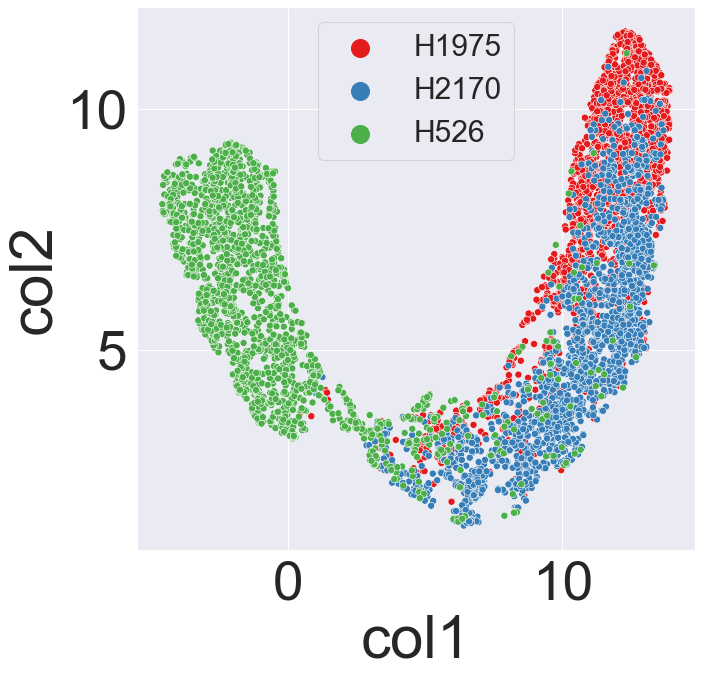

In [162]:
plt.figure(figsize=(10,10))
#plt.axis('off')
sns.scatterplot(data=df_F, x="col1", y="col2", s=50, hue="ClassLabels1", palette=('Set1'))
plt.legend(markerscale=3, fontsize=30)